# Raster Statistics

In [2]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
import pyspark
from pyspark.sql import SparkSession
from pathlib import Path

resource_dir = Path('./samples').resolve()

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()
# spark.sparkContext.setLogLevel("ERROR")

rf = spark.read.geotiff(resource_dir.joinpath("L8-B8-Robinson-IL.tiff").as_uri())

RasterFrames has a number of extension methods and columnar functions for performing analysis on tiles.

## Tile Statistics 

### Tile Dimensions

Get the nominal tile dimensions. Depending on the tiling there may be some tiles with different sizes on the edges.

In [3]:
rf.select(rf.spatialKeyColumn(), tileDimensions("tile")).show()

+-----------+---------------+
|spatial_key|dimension(tile)|
+-----------+---------------+
|      [2,1]|      [194,250]|
|      [0,0]|      [194,250]|
|      [3,1]|      [194,250]|
|      [1,0]|      [194,250]|
|      [3,0]|      [194,250]|
|      [0,1]|      [194,250]|
|      [1,1]|      [194,250]|
|      [2,0]|      [194,250]|
+-----------+---------------+



### Descriptive Statistics

#### NoData Counts

Count the numer of `NoData` and non-`NoData` cells in each tile.

In [4]:
rf.select(rf.spatialKeyColumn(), noDataCells("tile"), dataCells("tile")).show()

+-----------+-----------------+---------------+
|spatial_key|noDataCells(tile)|dataCells(tile)|
+-----------+-----------------+---------------+
|      [2,1]|                0|          48500|
|      [0,0]|                0|          48500|
|      [3,1]|                0|          48500|
|      [1,0]|                0|          48500|
|      [3,0]|                0|          48500|
|      [0,1]|                0|          48500|
|      [1,1]|                0|          48500|
|      [2,0]|                0|          48500|
+-----------+-----------------+---------------+



#### Tile Mean

Compute the mean value in each tile. Use `tileMean` for integral cell types, and `tileMeanDouble` for floating point
cell types.

In [5]:
rf.select(rf.spatialKeyColumn(), tileMean("tile")).show(3)

+-----------+------------------+
|spatial_key|    tileMean(tile)|
+-----------+------------------+
|      [2,1]|10607.318082474227|
|      [0,0]|10488.786144329897|
|      [3,1]|10579.939030927835|
+-----------+------------------+
only showing top 3 rows



#### Tile Summary Statistics

Compute a suite of summary statistics for each tile. Use `tileStats` for integral cells types, and `tileStatsDouble`
for floating point cell types.

## Plotting 
Data can be extracted and plotted with matplotlib. 

In [ ]:
# Graph the mins, maxes, and means all at once
mins = list(map(lambda x: x[0], 
         rf.withColumn("stats", tileStats("tile")).select(rf.spatialKeyColumn(), "stats.*").select("min").collect()))
maxes = list(map(lambda x: x[0], 
         rf.withColumn("stats", tileStats("tile")).select(rf.spatialKeyColumn(), "stats.*").select("max").collect()))
means = list(map(lambda x: x[0], 
         rf.withColumn("stats", tileStats("tile")).select(rf.spatialKeyColumn(), "stats.*").select("mean").collect()))

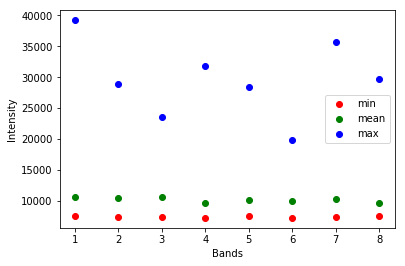

In [64]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

bands = range(1, 9)
plt.xlabel("Bands")
plt.ylabel("Intensity")
plt.plot(bands, mins, 'ro', label='min')
plt.plot(bands, means, 'go', label='mean')
plt.plot(bands, maxes, 'bo', label='max')
plt.legend()
plt.show()

In [6]:
rf.withColumn("stats", tileStats("tile")).select(rf.spatialKeyColumn(), "stats.*").show(3)

+-----------+---------+-----------+------+-------+------------------+------------------+
|spatial_key|dataCells|noDataCells|   min|    max|              mean|          variance|
+-----------+---------+-----------+------+-------+------------------+------------------+
|      [2,1]|    48500|         -1|7485.0|39217.0|10607.318082474267| 4232526.804534888|
|      [0,0]|    48500|         -1|7291.0|28869.0|10488.786144329813| 2590842.233358533|
|      [3,1]|    48500|         -1|7393.0|23590.0|10579.939030927824|2855749.7320972127|
+-----------+---------+-----------+------+-------+------------------+------------------+
only showing top 3 rows



### Histogram

The `tileHistogram` function computes a histogram over the data in each tile. See the 
@scaladoc[GeoTrellis `Histogram`](geotrellis.raster.histogram.Histogram) documentation for details on what's
available in the resulting data structure. Use this version for integral cell types, and `tileHistorgramDouble` for
floating  point cells types. 

In this example we compute quantile breaks.

In [21]:
hists = list(map(lambda x: (x[0].bins), rf.select(tileHistogram("tile")).collect()))

In [23]:
binList = []
for hist in hists:
    for bins in hist:
        binList.append((bins[0], bins[1]))

In [20]:
rf.withSpatialIndex().show()

+-----------+--------------------+--------------------+--------------------+-------------------+
|spatial_key|              bounds|            metadata|                tile|      spatial_index|
+-----------+--------------------+--------------------+--------------------+-------------------+
|      [0,1]|POLYGON ((431902....|Map(AREA_OR_POINT...|geotrellis.raster...|2777272668632429122|
|      [1,1]|POLYGON ((434805 ...|Map(AREA_OR_POINT...|geotrellis.raster...|2777272733439207797|
|      [0,0]|POLYGON ((431902....|Map(AREA_OR_POINT...|geotrellis.raster...|2777272837976870952|
|      [1,0]|POLYGON ((434805 ...|Map(AREA_OR_POINT...|geotrellis.raster...|2777272905362233268|
|      [2,1]|POLYGON ((437707....|Map(AREA_OR_POINT...|geotrellis.raster...|2777273476482717026|
|      [3,1]|POLYGON ((440610 ...|Map(AREA_OR_POINT...|geotrellis.raster...|2777273540982528781|
|      [2,0]|POLYGON ((437707....|Map(AREA_OR_POINT...|geotrellis.raster...|2777273648438972158|
|      [3,0]|POLYGON ((440610 

This is a plot of the histograms that were just computer across several of the tiles. While not particularly meaningful, this is an example of how one would create a basic scatterplot.

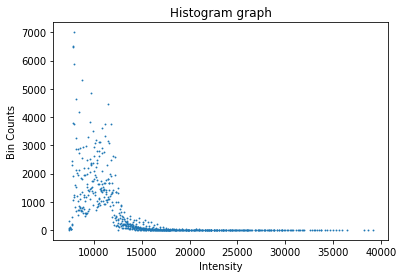

In [55]:
unzipped = list(zip(*binList))

fig, ax = plt.subplots()
plt.scatter(unzipped[0], unzipped[1], s=.75)
plt.xlabel("Intensity")
plt.ylabel("Bin Counts")
plt.title('Histogram graph')
plt.show()

## Aggregate Statistics

The `aggStats` function computes the same summary statistics as `tileStats`, but aggregates them over the whole 
RasterFrame.

In [47]:
rf.select(aggStats("tile")).show(truncate=False)

+---------------------------------------------------------------+
|aggStats(tile)                                                 |
+---------------------------------------------------------------+
|[388000,0,7209.0,39217.0,10160.657951030928,3315112.9759380817]|
+---------------------------------------------------------------+

